In [ ]:
# STEP 1: Install dependencies
!pip install torch torchvision matplotlib tqdm numpy pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [2]:
import os

def count_jpg_files(directory):
    count = 0
    for filename in os.listdir(directory):
        if filename.lower().endswith('.jpg'):
            count += 1
    return count

# Example usage
directory_path = '/content/sample_data/CHAOS/Train'
jpg_count = count_jpg_files(directory_path)
print(f"Number of .jpg files: {jpg_count}")


Number of .jpg files: 300


In [3]:
#Import the libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
# ========== Dataset ==========
class CTImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.lower().endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

data_path = "/content/sample_data/CHAOS/Train"
dataset = CTImageDataset(image_dir=data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [5]:
# ========== Generator ==========
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.block(x)

class UNetGenerator(nn.Module):
    def __init__(self, in_channels=1, base_channels=64):
        super().__init__()
        self.enc1 = UNetBlock(in_channels, base_channels)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = UNetBlock(base_channels, base_channels * 2)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = UNetBlock(base_channels * 2, base_channels * 4)

        self.up2 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 2, stride=2)
        self.dec2 = UNetBlock(base_channels * 4, base_channels * 2)
        self.up1 = nn.ConvTranspose2d(base_channels * 2, base_channels, 2, stride=2)
        self.dec1 = UNetBlock(base_channels * 2, base_channels)

        self.final = nn.Sequential(
            nn.Conv2d(base_channels, in_channels, 1),
            nn.Tanh()
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.final(d1)


In [6]:
# ========== Discriminator ==========
class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.InstanceNorm2d(128),#nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.InstanceNorm2d(128),#nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [7]:
# ========== Diffusion Scheduler ==========
class DiffusionScheduler:
    def __init__(self, timesteps=1000):
        self.timesteps = timesteps
        self.betas = self._cosine_beta_schedule(timesteps)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = np.cumprod(self.alphas)
        self.sqrt_alphas_cumprod = torch.tensor(np.sqrt(self.alphas_cumprod), dtype=torch.float32)
        self.sqrt_one_minus_alphas_cumprod = torch.tensor(np.sqrt(1 - self.alphas_cumprod), dtype=torch.float32)

    def _cosine_beta_schedule(self, timesteps, s=0.008):
        steps = timesteps + 1
        x = np.linspace(0, timesteps, steps)
        alphas_cumprod = np.cos(((x / timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return np.clip(betas, 0.0001, 0.9999)

    def add_noise(self, x, t):
        noise = torch.randn_like(x)
        t = t.long()

        # Move scheduler tensors to the same device as input `x`
        self.sqrt_alphas_cumprod = self.sqrt_alphas_cumprod.to(x.device)
        self.sqrt_one_minus_alphas_cumprod = self.sqrt_one_minus_alphas_cumprod.to(x.device)

        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t][:, None, None, None]
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t][:, None, None, None]

        return sqrt_alphas_cumprod_t * x + sqrt_one_minus_alphas_cumprod_t * noise, noise

In [8]:
# ========== Training ==========
def train(generator, discriminator, dataloader, scheduler, device, num_epochs=30):
    gen_opt = optim.Adam(generator.parameters(), lr=1e-4)
    disc_opt = optim.Adam(discriminator.parameters(), lr=1e-4)

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()

    max_timesteps = scheduler.timesteps

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        # Gradually increase noise level during training
        t_max = int(np.interp(epoch, [0, num_epochs * 0.5], [300, max_timesteps]))
        t_min = 0

        for real in tqdm(dataloader):
            real = real.to(device)
            bs = real.size(0)

            # Curriculum sampling
            t = torch.randint(t_min, t_max, (bs,), device=device)
            noised, noise = scheduler.add_noise(real, t)

            pred_noise = generator(noised)
            reconstructed = noised - pred_noise

            # === Discriminator ===
            disc_real = discriminator(real)
            disc_fake = discriminator(reconstructed.detach())
            real_labels = torch.ones_like(disc_real)
            fake_labels = torch.zeros_like(disc_fake)

            loss_disc = bce_loss(disc_real, real_labels) + bce_loss(disc_fake, fake_labels)
            disc_opt.zero_grad()
            loss_disc.backward()
            disc_opt.step()

            # === Generator ===
            disc_fake = discriminator(reconstructed)
            loss_gen = mse_loss(pred_noise, noise) + 0.05 * bce_loss(disc_fake, real_labels)
            gen_opt.zero_grad()
            loss_gen.backward()
            gen_opt.step()

        print(f"Loss Gen: {loss_gen.item():.4f}, Loss Disc: {loss_disc.item():.4f}")

        # Optional: visualize results during training
        if (epoch + 1) % 10 == 0:
            visualize(generator, scheduler, dataloader, device, epoch=epoch, total_epochs=num_epochs)

    # Save model after training
    torch.save(generator.state_dict(), "diffusion_gan_generator.pth")
    print("Model saved as 'diffusion_gan_generator.pth'.")

In [9]:
# ========== Visualization ==========
def visualize(generator, scheduler, dataloader, device, epoch=None, total_epochs=100):
    generator.eval()
    with torch.no_grad():
        real = next(iter(dataloader)).to(device)
        bs = real.size(0)

        # Use curriculum-based t_max if epoch is provided
        if epoch is not None:
            t_max = int(np.interp(epoch, [0, total_epochs * 0.5], [300, scheduler.timesteps]))
        else:
            t_max = 700  # default fallback
        t_min = 0

        t = torch.randint(t_min, t_max, (bs,), device=device)

        noised, _ = scheduler.add_noise(real, t)
        pred_noise = generator(noised)
        reconstructed = noised - pred_noise

        for i in range(1):  # show only 1 sample
            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(real[i].cpu().squeeze(), cmap='gray')
            axs[0].set_title("Original")
            axs[1].imshow(noised[i].cpu().squeeze(), cmap='gray')
            axs[1].set_title("Noised (t = {})".format(t[i].item()))
            axs[2].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
            axs[2].set_title("Generated")
            for ax in axs:
                ax.axis("off")
            plt.tight_layout()
            plt.show()
    generator.train()


Epoch 1/30


100%|██████████| 19/19 [00:02<00:00,  7.11it/s]


Loss Gen: 0.9838, Loss Disc: 1.2723

Epoch 2/30


100%|██████████| 19/19 [00:02<00:00,  7.24it/s]


Loss Gen: 0.8195, Loss Disc: 1.2521

Epoch 3/30


100%|██████████| 19/19 [00:02<00:00,  7.19it/s]


Loss Gen: 0.5718, Loss Disc: 1.2292

Epoch 4/30


100%|██████████| 19/19 [00:02<00:00,  7.08it/s]


Loss Gen: 0.4897, Loss Disc: 1.1172

Epoch 5/30


100%|██████████| 19/19 [00:02<00:00,  7.14it/s]


Loss Gen: 0.4197, Loss Disc: 1.0486

Epoch 6/30


100%|██████████| 19/19 [00:02<00:00,  7.07it/s]


Loss Gen: 0.4068, Loss Disc: 0.9787

Epoch 7/30


100%|██████████| 19/19 [00:02<00:00,  7.04it/s]


Loss Gen: 0.2825, Loss Disc: 0.9249

Epoch 8/30


100%|██████████| 19/19 [00:02<00:00,  6.99it/s]


Loss Gen: 0.3866, Loss Disc: 0.9040

Epoch 9/30


100%|██████████| 19/19 [00:02<00:00,  6.91it/s]


Loss Gen: 0.2972, Loss Disc: 0.8583

Epoch 10/30


100%|██████████| 19/19 [00:02<00:00,  6.94it/s]


Loss Gen: 0.3527, Loss Disc: 0.8302


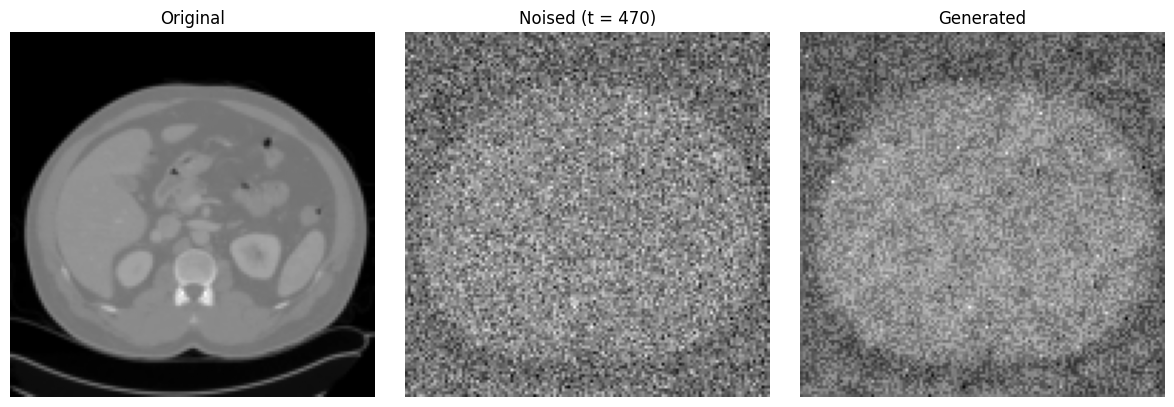


Epoch 11/30


100%|██████████| 19/19 [00:02<00:00,  6.83it/s]


Loss Gen: 0.2785, Loss Disc: 0.7775

Epoch 12/30


100%|██████████| 19/19 [00:02<00:00,  6.79it/s]


Loss Gen: 0.3288, Loss Disc: 0.7758

Epoch 13/30


100%|██████████| 19/19 [00:03<00:00,  6.23it/s]


Loss Gen: 0.2705, Loss Disc: 0.6938

Epoch 14/30


100%|██████████| 19/19 [00:02<00:00,  6.68it/s]


Loss Gen: 0.2952, Loss Disc: 0.6570

Epoch 15/30


100%|██████████| 19/19 [00:02<00:00,  6.65it/s]


Loss Gen: 0.2737, Loss Disc: 0.6225

Epoch 16/30


100%|██████████| 19/19 [00:02<00:00,  6.60it/s]


Loss Gen: 0.3014, Loss Disc: 0.5744

Epoch 17/30


100%|██████████| 19/19 [00:02<00:00,  6.55it/s]


Loss Gen: 0.3080, Loss Disc: 0.5369

Epoch 18/30


100%|██████████| 19/19 [00:02<00:00,  6.63it/s]


Loss Gen: 0.2875, Loss Disc: 0.5168

Epoch 19/30


100%|██████████| 19/19 [00:02<00:00,  6.67it/s]


Loss Gen: 0.2896, Loss Disc: 0.4523

Epoch 20/30


100%|██████████| 19/19 [00:02<00:00,  6.68it/s]


Loss Gen: 0.3337, Loss Disc: 0.4418


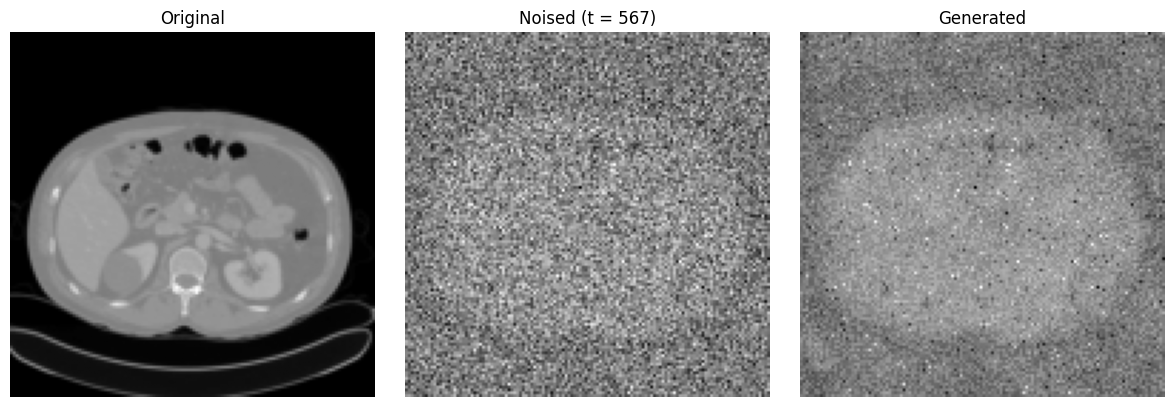


Epoch 21/30


100%|██████████| 19/19 [00:02<00:00,  6.70it/s]


Loss Gen: 0.3281, Loss Disc: 0.3955

Epoch 22/30


100%|██████████| 19/19 [00:02<00:00,  6.80it/s]


Loss Gen: 0.3052, Loss Disc: 0.3555

Epoch 23/30


100%|██████████| 19/19 [00:02<00:00,  6.82it/s]


Loss Gen: 0.3396, Loss Disc: 0.3544

Epoch 24/30


100%|██████████| 19/19 [00:02<00:00,  6.86it/s]


Loss Gen: 0.2970, Loss Disc: 0.3287

Epoch 25/30


100%|██████████| 19/19 [00:02<00:00,  6.85it/s]


Loss Gen: 0.2792, Loss Disc: 0.3028

Epoch 26/30


100%|██████████| 19/19 [00:02<00:00,  6.89it/s]


Loss Gen: 0.3324, Loss Disc: 0.2906

Epoch 27/30


100%|██████████| 19/19 [00:02<00:00,  6.89it/s]


Loss Gen: 0.2940, Loss Disc: 0.2818

Epoch 28/30


100%|██████████| 19/19 [00:02<00:00,  6.94it/s]


Loss Gen: 0.2919, Loss Disc: 0.2558

Epoch 29/30


100%|██████████| 19/19 [00:02<00:00,  6.91it/s]


Loss Gen: 0.2905, Loss Disc: 0.2542

Epoch 30/30


100%|██████████| 19/19 [00:02<00:00,  6.96it/s]


Loss Gen: 0.2854, Loss Disc: 0.2530


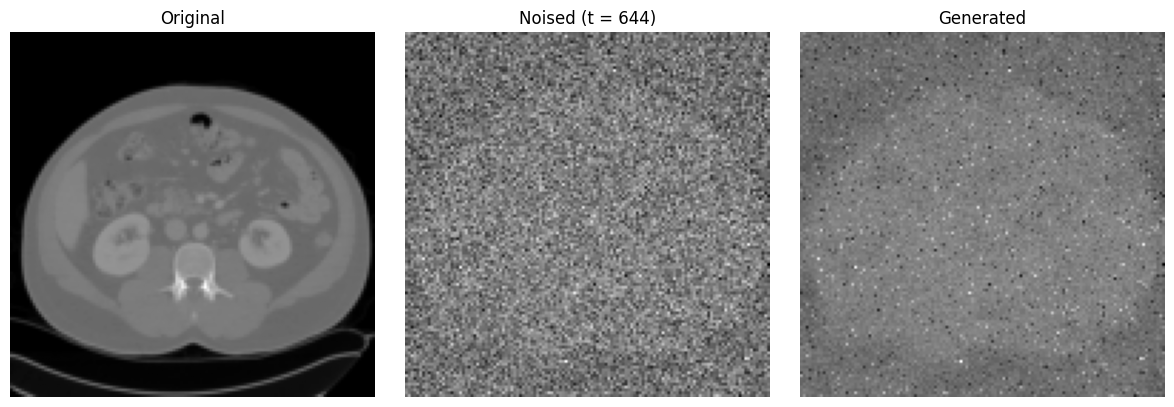

Model saved as 'diffusion_gan_generator.pth'.


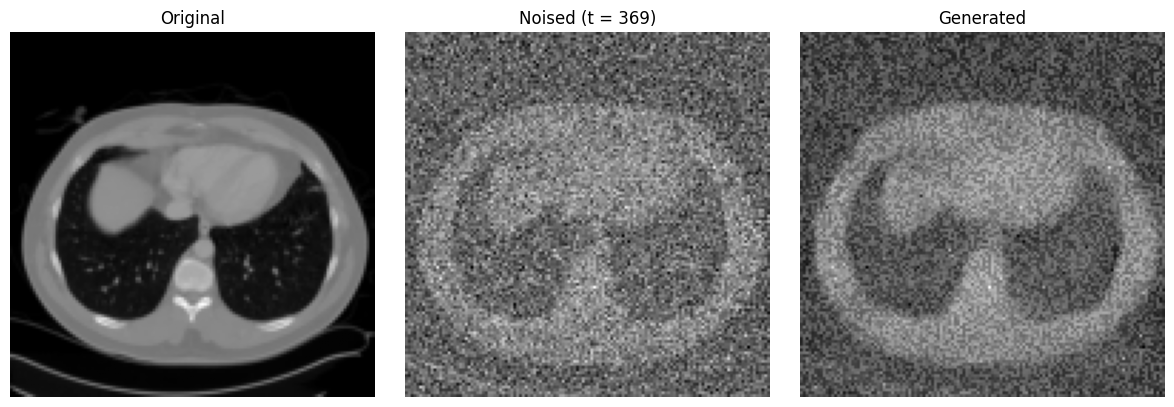

In [11]:
# ========== Run Training ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = UNetGenerator().to(device)
discriminator = Discriminator().to(device)
scheduler = DiffusionScheduler(timesteps=1000)

train(generator, discriminator, dataloader, scheduler, device, num_epochs=30)
visualize(generator, scheduler, dataloader, device)

In [12]:
def generate_images(generator, scheduler, dataloader, device, num_images=10, save_dir="generated_images"):
    generator.eval()
    os.makedirs(save_dir, exist_ok=True)

    count = 0
    with torch.no_grad():
        for real in dataloader:
            real = real.to(device)
            bs = real.size(0)

            # Sample random timesteps
            t = torch.randint(0, scheduler.timesteps, (bs,), device=device)
            noised, _ = scheduler.add_noise(real, t)

            # Predict noise and reconstruct
            pred_noise = generator(noised)
            reconstructed = noised - pred_noise

            # Save images
            for i in range(bs):
                if count >= num_images:
                    return
                img = reconstructed[i].cpu().squeeze().clamp(-1, 1) * 0.5 + 0.5  # unnormalize to [0, 1]
                img = transforms.ToPILImage()(img)
                img.save(os.path.join(save_dir, f"synthetic_{count:03d}.png"))
                count += 1

generate_images(generator, scheduler, dataloader, device, num_images=10, save_dir="/content/sample_data/Synthetic_CT")